# Anomaly Detection

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
plt.style.use('ggplot')

In [2]:
plt.rcParams['font.family']='serif'
plt.rcParams['font.serif']='Ubuntu'
plt.rcParams['font.monospace']='Ubuntu Mono'
plt.rcParams['font.size']=12
plt.rcParams['axes.labelsize']=11
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['axes.titlesize']=12
plt.rcParams['xtick.labelsize']=9
plt.rcParams['ytick.labelsize']=9
plt.rcParams['legend.fontsize']=11
plt.rcParams['figure.titlesize']=13

In [3]:
from numpy import genfromtxt
from scipy.stats import multivariate_normal
from sklearn.metrics import f1_score

In [4]:
def read_dataset(filePath,delimiter=','):
    return genfromtxt(filePath,delimiter=delimiter)

def feature_normalize(dataset):
    mu=npmmean(dataset,axis=0)
    sigma=np.std(dataset,axis=0)
    return (dataset-mu)/sigma

def estimateGuassian(dataset):
    mu=np.mean(dataset,axis=0)
    sigma=np.cov(dataset.T)
    return mu,sigma
def multivariateGaussian(dataset,mu,sigma):
    p=multivariate_normal(mean=mu,cov=sigma)
    return p.pdf(dataset)
def selectThresholdByCV(probs,get):
    best_epsilon=0
    best_f1=0
    f=0
    stepsize=(max(probs)-min(probs))/1000
    epsilons=np.arange(min(probs),max(probs),stepsize)
    for epsilon in np.nditer(epsilons):
        predictions=(probs<epsilon) #numpy array of True/False
        f=f1_score(gt_data,predictions,average='binary')
        if f>best_f1:
            best_f1=f
            best_epsilon=epsilon
            
    return best_f1,best_epsilon

In [5]:
pd.read_csv('./tr_server_data.csv').head()

,13.047,14.741
0,13.409,13.763
1,14.196,15.853
2,14.915,16.174
3,13.577,14.043
4,13.922,13.406


In [6]:
pd.read_csv('./cv_server_data.csv').head()

,15.79,14.921
0,13.640,15.330
1,14.866,16.474
2,13.585,13.989
3,13.464,15.635
4,12.949,16.140


In [7]:
pd.read_csv('./gt_server_data.csv').head()
# entires are 1 and rest are 0

,0
0,0
1,0
2,0
3,0
4,0


In [8]:
tr_data=read_dataset('tr_server_data.csv')
print(tr_data[0:5])
print(tr_data.shape)

[[13.047 14.741]
 [13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]
(307, 2)


In [9]:
cv_data=read_dataset('cv_server_data.csv')
print(cv_data[0:5])
print(cv_data.shape)

[[15.79  14.921]
 [13.64  15.33 ]
 [14.866 16.474]
 [13.585 13.989]
 [13.464 15.635]]
(307, 2)


In [10]:
gt_data=read_dataset('gt_server_data.csv')
print(gt_data[0:5])
print(gt_data.shape)

[0. 0. 0. 0. 0.]
(307,)


In [11]:
n_training_samples=tr_data.shape[0]
n_dim=tr_data.shape[1]

In [12]:
print('Number of datapoints i training set: ',n_training_samples)
print('Number of dimensions/features: ',n_dim)

Number of datapoints i training set:  307
Number of dimensions/features:  2


In [13]:
print(tr_data[1:5])

[[13.409 13.763]
 [14.196 15.853]
 [14.915 16.174]
 [13.577 14.043]]


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


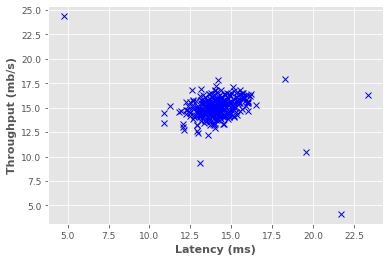

In [14]:
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.show()

### Anomaly Detection Using MultiVariateGaussian

In [15]:
mu,sigma=estimateGuassian(tr_data)
print(mu)
print(sigma)

[14.11225277 14.99767459]
[[ 1.83866684 -0.22783493]
 [-0.22783493  1.71530264]]


In [16]:
p=multivariateGaussian(tr_data,mu,sigma)
p[0:4]

array([0.06346609, 0.04706598, 0.07222892, 0.04681638])

In [17]:
#Finding the optimal epsilon using cross validation
p_cv=multivariateGaussian(cv_data,mu,sigma)
fscore,ep=selectThresholdByCV(p_cv,gt_data)
print(fscore,ep)

0.8750000000000001 9.036201327981212e-05


In [18]:
#Selecting outlier datapoints
outliers=np.asarray(np.where(p<ep))
outliers

array([[300, 301, 303, 304, 305, 306]], dtype=int64)

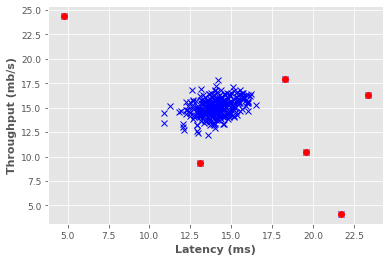

In [19]:
plt.figure()
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.plot(tr_data[:,0],tr_data[:,1],'bx')
plt.plot(tr_data[outliers,0],tr_data[outliers,1],'ro')
plt.show()

### Anomaly Detection Using One-Class SVM

In [20]:
from sklearn import svm

In [21]:
tr_data=read_dataset('tr_server_data.csv')

In [22]:
clf=svm.OneClassSVM(nu=0.05,kernel='rbf',gamma=0.1)
clf.fit(tr_data)

OneClassSVM(gamma=0.1, nu=0.05)

In [23]:
pred=clf.predict(tr_data)
print(np.sum(pred==1)) #number of inliers
print(np.sum(pred==-1)) #number of outliers

291
16


In [24]:
good=tr_data[pred==1]
bad=tr_data[pred==-1]

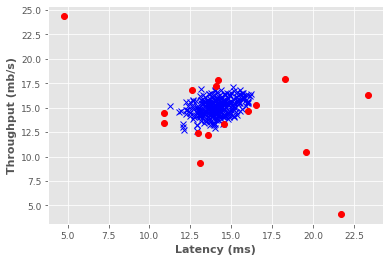

In [25]:
plt.figure()
plt.plot(good[:,0],good[:,1],'bx')
plt.plot(bad[:,0],bad[:,1],'ro')
plt.xlabel('Latency (ms)')
plt.ylabel('Throughput (mb/s)')
plt.show()